In [175]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [6]:
emotions = pd.read_csv("daylio-export-H2.csv")
emotions.head()

,full_date,date,weekday,time,mood,activities,note_title,note
0,2024-01-10,10 stycznia,środa,20:17,tak sobie,zmęczenie | stres | smutek | desperacja | duma...,NaN,NaN
1,2024-01-09,9 stycznia,wtorek,12:58,dobrze,szczęście | zadowolenie | zmęczenie | stres | ...,NaN,NaN
2,2024-01-08,8 stycznia,poniedziałek,20:14,dobrze,szczęście | podniecenie | zadowolenie | stres ...,NaN,NaN
3,2024-01-07,7 stycznia,niedziela,23:59,źle,złość | smutek,NaN,NaN
4,2024-01-07,7 stycznia,niedziela,14:00,dobrze,szczęście | relaks | zadowolenie | stres | zai...,NaN,NaN


In [7]:
emotions['activities'] = emotions['activities'].apply(lambda x: set(x.split(' | ')))

In [92]:
emotions.head(5)

,full_date,date,weekday,time,mood,activities,note_title,note
0,2024-01-10,10 stycznia,środa,20:17,tak sobie,"{zmęczenie, spełnienie, pij wodę, projekt grup...",NaN,NaN
1,2024-01-09,9 stycznia,wtorek,12:58,dobrze,"{szczęście, zmęczenie, pij wodę, projekt grupo...",NaN,NaN
2,2024-01-08,8 stycznia,poniedziałek,20:14,dobrze,"{szczęście, pij wodę, zainteresowanie, wieczór...",NaN,NaN
3,2024-01-07,7 stycznia,niedziela,23:59,źle,"{złość, smutek}",NaN,NaN
4,2024-01-07,7 stycznia,niedziela,14:00,dobrze,"{szczęście, pij wodę, zainteresowanie, relaks,...",NaN,NaN


In [42]:
# Create a list to store edges and their frequencies
edges_data = []

for activities_set in emotions['activities']:
    activities_list = list(activities_set)

    activity_pairs = [(activities_list[i], activities_list[j]) for i in range(len(activities_list)) for j in range(i + 1, len(activities_list))]

    for pair in activity_pairs:
        index = next((i for i, item in enumerate(edges_data) if item['source'] == pair[0] and item['target'] == pair[1]), None)
        if index is not None:
            edges_data[index]['freq'] += 1
        else:
            edges_data.append({'source': pair[0], 'target': pair[1], 'freq': 1})

df_edges = pd.DataFrame(edges_data)
df_edges

,source,target,freq
0,zmęczenie,spełnienie,4
1,zmęczenie,pij wodę,6
2,zmęczenie,projekt grupowy,4
3,zmęczenie,nauka,2
4,zmęczenie,dbaj o zdrowie,2
...,...,...,...
3130,chłodno,rozmawiaj,1
3131,chłodno,alkohol,1
3132,rozmawiaj,alkohol,1
3133,ćwiczenie,alkohol,1


In [53]:
df_edges.sort_values("freq", ascending = False)

,source,target,freq
337,filmy i tv,domowy,22
525,brak zajęć,domowy,20
491,dobry sen,domowy,18
411,skup się,domowy,18
155,filmy i tv,skup się,18
...,...,...,...
1813,medytacja,niepokój,1
1812,sam,praca domowa,1
1811,sam,zrób listę,1
1810,sam,stomatolog,1


In [66]:
df_edges_fil = df_edges.query('freq >= 8')

In [82]:
a1 = df_edges_fil.loc[:,"source"].unique()
a2 = df_edges_fil.loc[:, "target"].unique()
a3 = np.concatenate([a1,a2])
unique_act = np.unique(a3)

In [84]:
activity_frequency = {}

for activities_set in emotions['activities']:
    for activity in activities_set:
        activity_frequency[activity] = activity_frequency.get(activity, 0) + 1

df_activity_frequency = pd.DataFrame(list(activity_frequency.items()), columns=['activity', 'total_frequency'])

In [111]:
df_act_freq_filtered = df_activity_frequency[df_activity_frequency['activity'].isin(unique_act)]
df_act_freq_filtered.head(10)
activity_frequency_dict = df_act_freq_filtered.set_index('activity')['total_frequency'].to_dict()
activity_frequency_dict

{'zmęczenie': 13,
 'spełnienie': 12,
 'pij wodę': 19,
 'projekt grupowy': 13,
 'nauka': 11,
 'zimno': 12,
 'filmy i tv': 27,
 'sam': 13,
 'stres': 14,
 'dobry sen': 20,
 'słodycze': 17,
 'spacer': 15,
 'wiatr': 9,
 'witaminy': 18,
 'skup się': 21,
 'szczęście': 16,
 'zadowolenie': 10,
 'gotowanie': 13,
 'mycie naczyń': 14,
 'pochmurno': 16,
 'domowy': 30,
 'wieczór z drugą połówką': 11,
 'brak zajęć': 21,
 'pielęgnacja skóry': 15,
 'relaks': 22,
 'zdrowe odżywianie się': 8,
 'niepokój': 12,
 'ulga': 11,
 'rodzina': 11}

In [202]:
graph = nx.from_pandas_edgelist(df_edges_fil, edge_attr=True)
nx.set_node_attributes(graph, activity_frequency_dict, "freq")
pos = nx.spring_layout(graph, k = 2, seed = 44)

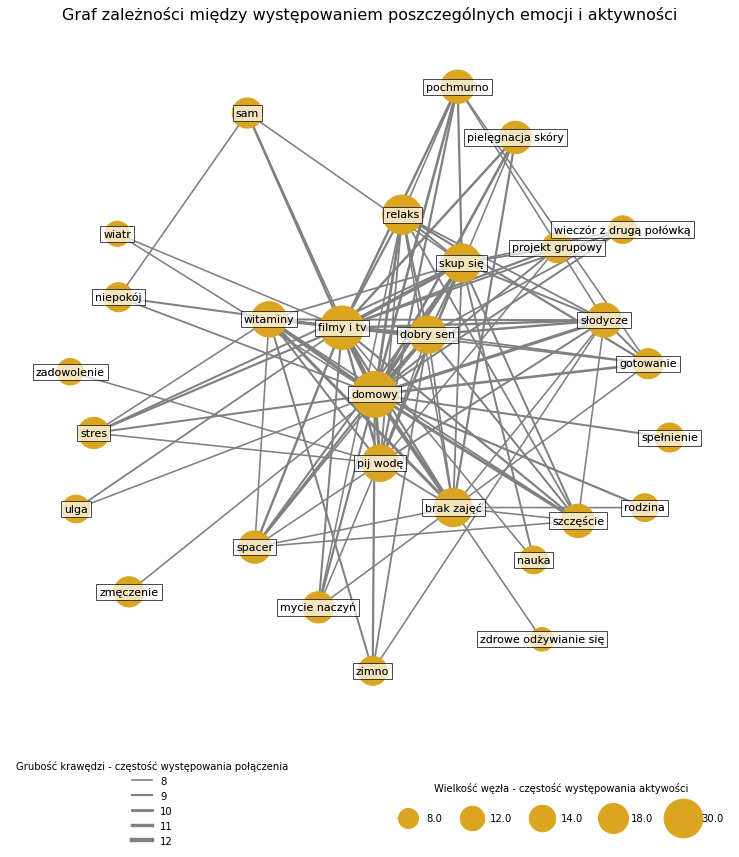

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(13, 13))
nx.draw(graph, 
        pos = pos,
        with_labels=True, 
        node_color="goldenrod", 
        edge_color="gray",
        node_size=[v[1]["freq"] * 70 for v in graph.nodes(data=True)], 
        width=[e[2]["freq"] * 0.2 for e in graph.edges(data=True)],
        font_size = 11,
       )

plt.title("Graf zależności między występowaniem poszczególnych emocji i aktywności", fontsize = 16)
label_options = {'ec': 'k', 'fc': 'white', 'alpha': 0.7, 'pad': 3}
nx.draw_networkx_labels(graph, pos = pos, font_size=11, bbox=label_options)

node_sizes = [v[1]["freq"] for v in graph.nodes(data=True)]
for v in np.quantile(node_sizes, np.linspace(0, 1, 5)):
    ax.plot([], [], color = "goldenrod", marker = "o", markersize=np.sqrt(v * 50), label=v) # Trzeba wziąć pierwiastek żeby wielkości były takie same jak na grafie
first_legend = ax.legend(
    labelspacing=2, title="Wielkość węzła - częstość występowania aktywości", frameon=False, ncol=5, loc="center right", bbox_to_anchor=(1, -0.1)
)
ax.add_artist(first_legend)

edge_sizes = [e[2]["freq"] for e in graph.edges(data=True)]
ax.legend(
    handles=[mpl.lines.Line2D([], [], color="grey", linewidth=e*0.2) for e in np.quantile(np.unique(edge_sizes), np.linspace(0, 1, 5))],
    labels=list(np.unique(edge_sizes)),
    loc = "center left", 
    bbox_to_anchor=(0, -0.1),
    frameon=False,
    title="Grubość krawędzi - częstość występowania połączenia",
)

plt.savefig("./graf_aktywnosci.png")
plt.show()